In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.hodgkin_huxley import HH
from neurodynex3.tools import input_factory

from enum import Enum

# 1 Exploration of HH neurons

In [2]:
class ModelType(Enum):
    REGULAR = 1
    ADAPTIVE = 2

def plot_data(state_monitor, title=None, model_type : ModelType = ModelType.REGULAR, plot_ionic = True, vm_y_lim = None):
    """Plots the state_monitor variables ["vm", "I_e", "m", "n", "h"] vs. time.

    Args:
        state_monitor (StateMonitor): the data to plot
        title (string, optional): plot title to display
    """

    # Setup figure size
    plt.rcParams["figure.figsize"] = (min(15,8 * state_monitor.vm[0].shape[0] / 200),13)

    plt.subplot(611)
    plt.plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2)
    plt.xlabel("$t\ [ms]$", fontsize=12)
    plt.ylabel("$v\ [mV]$", fontsize=12, labelpad=20)
    if vm_y_lim is not None:
        plt.ylim(vm_y_lim)
    plt.grid()

    plt.subplot(612)
    plt.plot(state_monitor.t / b2.ms, state_monitor.I_e[0] / b2.uamp, lw=2)
    # plt.axis((
    #     0,
    #     np.max(state_monitor.t / b2.ms),
    #     min(state_monitor.I_e[0] / b2.uamp) * 1.1,
    #     max(state_monitor.I_e[0] / b2.uamp) * 1.1
    # ))
    plt.xlabel("$t\ [ms]$", fontsize=12)
    plt.ylabel("$I_{ext}\ [\mu A]$", fontsize=12, labelpad=25)
    plt.grid()


    plt.subplot(613)
    plt.plot(state_monitor.t / b2.ms, state_monitor.m[0]**3 / b2.volt, "black", lw=2)
    plt.plot(state_monitor.t / b2.ms, state_monitor.n[0]**4 / b2.volt, "blue", lw=2)
    plt.plot(state_monitor.t / b2.ms, state_monitor.h[0] / b2.volt, "red", lw=2)
    plt.xlabel("$t\ [ms]$", fontsize=12)
    plt.ylabel("gating variables", labelpad=25, fontsize=12)
    plt.legend(("$m^3$", "$n^4$", "$h$"), loc='upper right', fontsize=12)
    plt.ylim((-0.02, 1.05))
    plt.grid()
    

    if (plot_ionic):
        plt.subplot(614)

        plt.plot(state_monitor.t / b2.ms, state_monitor.I_Na[0] / b2.uamp, "blue", lw=2)
        plt.plot(state_monitor.t / b2.ms, state_monitor.I_K[0] / b2.uamp, "black", lw=2)
        plt.xlabel("$t\ [ms]$", fontsize=12)
        plt.ylabel("Ionic currents $[\mu A]$", fontsize=12, labelpad=25)
        plt.legend(("$I_{Na}$", "$I_K$"), loc='upper right', fontsize=12)
        plt.grid()

    if model_type == ModelType.ADAPTIVE:
        plt.subplot(615)
        plt.plot(state_monitor.t / b2.ms, state_monitor.I_M[0] / b2.uamp, "red", lw=2)
        plt.xlabel("$t\ [ms]$", fontsize=12)
        plt.ylabel("$I_M\ [\mu A]$", fontsize=12, labelpad=20)
        plt.grid()

        plt.subplot(616)
        plt.plot(state_monitor.t / b2.ms, state_monitor.p[0] / b2.volt, "black", lw=2)
        plt.xlabel("$t\ [ms]$", fontsize=12)
        plt.ylabel("$p$", fontsize=12, labelpad=22)
        #plt.legend(("$p\ $"), loc='upper right', fontsize=12)
        plt.ylim((-0.02, 1.05))
        plt.grid()

    if title is not None:
        plt.suptitle(title)

    plt.show()

## 1.1 Getting started

First we define the function to simulate the regular spiking neuron. It is the same as the basic Brian2 implementation, except the parameters and equations are the ones found in the pdf of the project.


In [3]:
def simulate_HH_neuron_regular(input_current, simulation_time):

    """A regular Hodgkin-Huxley neuron implemented in Brian2. Parameters are set 
    according to their values in the pdf.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h", "I_Na", "I_K"]
    """

    # neuron parameters with their specific values
    El = -70 * b2.mV 
    EK = -90 * b2.mV 
    ENa = 50 * b2.mV 
    gl = 0.1 * b2.msiemens 
    gK = 5 * b2.msiemens 
    gNa = 50 * b2.msiemens 
    C = 1 * b2.ufarad 

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    I_Na = gNa*m**3*h*(vm-ENa) : amp
    I_K = gK*n**4*(vm-EK) : amp
    I_L = gl*(vm-El)  : amp
    membrane_Im = I_e - I_Na  - I_L - I_K  : amp
    alphah = .128*exp(-(43. + vm/mV)/18.)/ms    : Hz
    alpham = -.32*(47. + vm/mV)/(exp(-0.25*(47.+vm/mV))-1)/ms : Hz
    alphan = -.032*(45. + vm/mV)/(exp(-0.2*(45.+vm/mV))-1)/ms : Hz
    betah = 4./(1+exp(-0.2*(20. + vm/mV)))/ms : Hz
    betam = 0.28*(20. + vm/mV)/(-1+exp(0.2*(20. + vm/mV)))/ms : Hz
    betan = .5*exp(-(50. + vm/mV)/40.)/ms : Hz
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = -70 * b2.mV
    neuron.m = 0
    neuron.h = 1
    neuron.n = 0

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h", "I_Na", "I_K"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

We simulate the neuron with no input current to check the stable point of each variable (vm, m, h, n)

The results are vm = -70, m = n = 0, h = 1

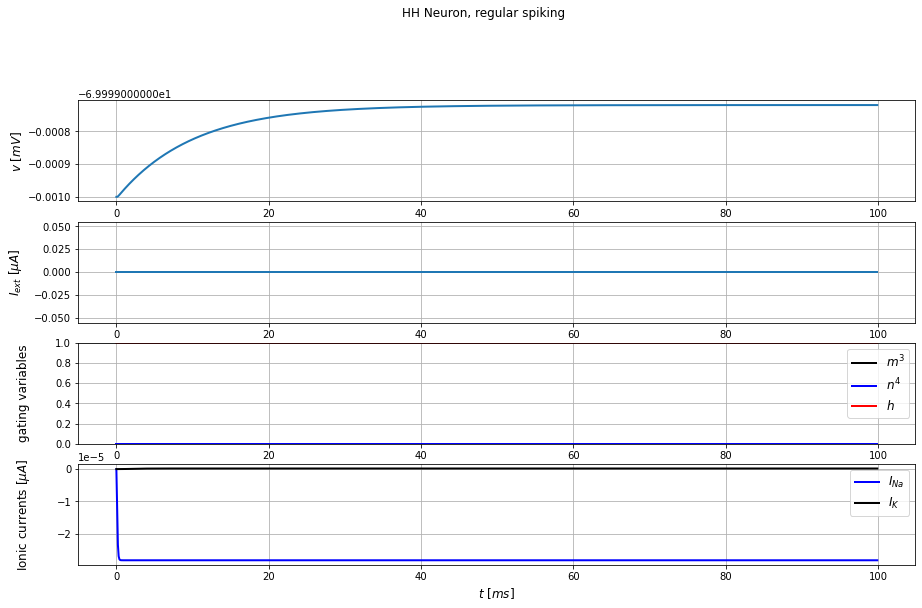

After a simulation of 100 ms, the gating variables reached the values: 
m : 0.0016757936665362503, n : 0.006540476088151904, h : 0.999683526447844, vm : -0.06999971956676725


In [30]:
#Simulations to find the stable point of each variable - regular neuron
I_min =0
sim_time = 100
current = input_factory.get_step_current(0, sim_time, b2.ms, I_min *b2.uA)
state_monitor = simulate_HH_neuron_regular(current, sim_time * b2.ms)
plot_data(state_monitor, title="HH Neuron, regular spiking")

print(f'After a simulation of {sim_time} ms, the gating variables reached the values: ')
print(f'm : {state_monitor.m[0,-1]}, n : {state_monitor.n[0,-1]}, h : {state_monitor.h[0,-1]}, vm : {state_monitor.vm[0,-1]}')

Now we define the function to simulate an adpative neuron (introducing the current I_M).

In [4]:
def simulate_HH_neuron_adaptive(input_current, simulation_time, ):

    """An adaptive Hodgkin-Huxley neuron implemented in Brian2. Parameters are set 
    according to their values in the pdf.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h", "I_Na", "I_K", "I_M", "I_L, "p"]
    """

    # neuron parameters with their specific values
    El = -70 * b2.mV 
    EK = -90 * b2.mV 
    ENa = 50 * b2.mV 
    gl = 0.1 * b2.msiemens 
    gK = 5 * b2.msiemens 
    gNa = 50 * b2.msiemens 
    gm = 0.07 * b2.msiemens
    C = 1 * b2.ufarad 

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    I_Na = gNa*m**3*h*(vm-ENa) : amp
    I_K = gK*n**4*(vm-EK) : amp
    I_L = gl*(vm-El)  : amp
    I_M = gm*p*(vm-EK): amp
    membrane_Im = I_e - I_Na  - I_L - I_K - I_M : amp
    alphah = .128*exp(-(43 + vm/mV)/18)/ms    : Hz
    alpham = -.32*(47 + vm/mV)/(exp(-0.25*(47+vm/mV))-1)/ms : Hz
    alphan = -.032*(45 + vm/mV)/(exp(-0.2*(45+vm/mV))-1)/ms : Hz
    betah = 4./(1+exp(-0.2*(20 + vm/mV)))/ms : Hz
    betam = 0.28*(20 + vm/mV)/(-1+exp(0.2*(20 + vm/mV)))/ms : Hz
    betan = .5*exp(-(50 + vm/mV)/40)/ms : Hz
    p_inf = 1./(1. + exp(-.1*(40 + vm/mV))) : 1
    t_p = 2000/(3.3*exp((20 + vm/mV)/20) + exp(-(20 + vm/mV)/20))*ms : second
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dp/dt = (p_inf - p)/t_p : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = -70.607 * b2.mV
    neuron.m = 0.001459
    neuron.h = 0.99972
    neuron.n = 0.00584
    neuron.p = 0.044756

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h", "I_Na", "I_K", "I_M", "I_L", "p"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

Simulating the neuron with no input gives the same stable points as before for all variables. We also set p = 0.

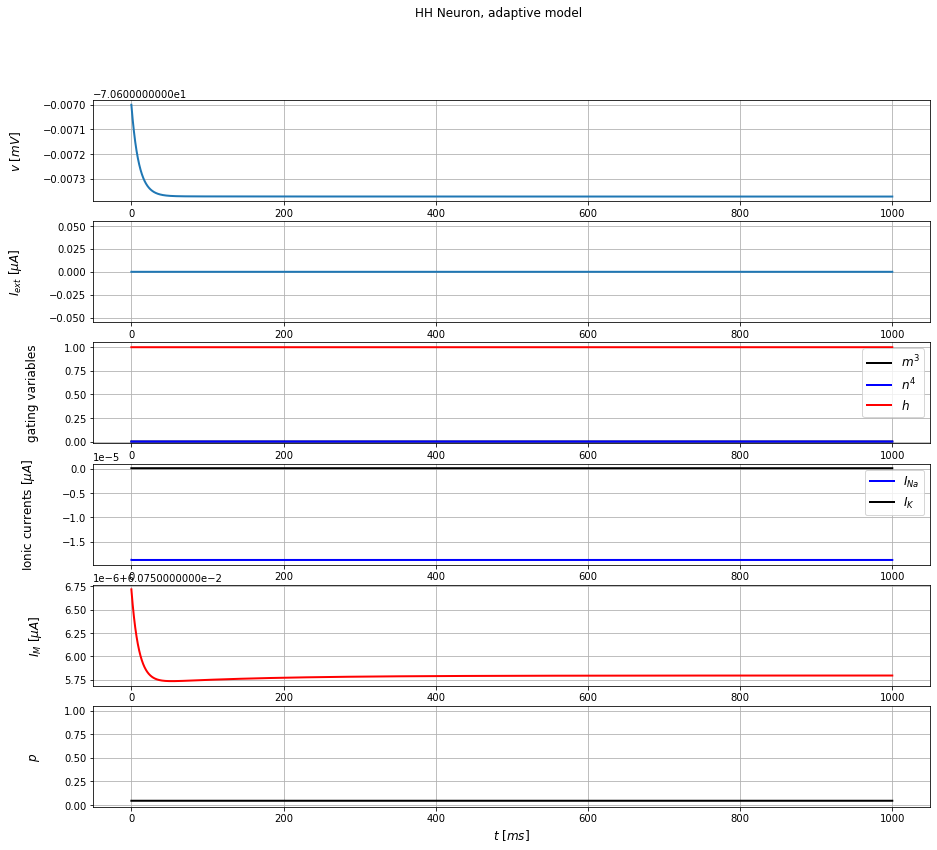

After a simulation of 1000 ms, the gating variables reached the values: 
m : 0.0014595714156515895, n : 0.005842914779623783, h : 0.9997290317823794, p : 0.04475617652923968,  vm : -0.07060737160274788 


In [26]:
#Simulations to find the stable point of each variable - adaptive neuron
I_min = 0
sim_time = 1000
current = input_factory.get_step_current(0, 0, b2.ms, I_min *b2.uA)
state_monitor = simulate_HH_neuron_adaptive(current, sim_time * b2.ms)
plot_data(state_monitor, title="HH Neuron, adaptive model", model_type=ModelType.ADAPTIVE)

print(f'After a simulation of {sim_time} ms, the gating variables reached the values: ')
print(f'm : {state_monitor.m[0,-1]}, n : {state_monitor.n[0,-1]}, h : {state_monitor.h[0,-1]}, p : {state_monitor.p[0,-1]},  vm : {state_monitor.vm[0,-1]} ')

## 1.2 Rebound spike?

The goal of this section is to assess the presence of a rebound spike resulting from a (negative) hyperpolarizing current. We define a new function to plot the gating variables, together with their time constants and their limit values.

In [5]:
def plot_gating_variables(state_monitor, title=None, model_type = ModelType.REGULAR):
    """Plots the state_monitor variables ["vm", "I_e", "m", "n", "h"] vs. time.

    Args:
        state_monitor (StateMonitor): the data to plot
        title (string, optional): plot title to display
    """
    plt.rcParams["figure.figsize"] = (min(15,8 * state_monitor.vm[0].shape[0] / 200),20)
    vm = state_monitor.vm[0] / b2.mV

    alphah = .128*np.exp(-(43 + vm)/18)
    alpham = -.32*(47 + vm)/(np.exp(-0.25*(47+vm))-1)
    alphan = -.032*(45 + vm)/(np.exp(-0.2*(45+vm))-1)
    betah = 4./(1+np.exp(-0.2*(20 + vm)))
    betam = 0.28*(20 + vm)/(-1+np.exp(0.2*(20 + vm)))
    betan = .5*np.exp(-(50 + vm)/40)

    t_m = 1 / (alpham + betam)
    t_n = 1 / (alphan + betan)
    t_h = 1 / (alphah + betah)

    m_inf = alpham * t_m
    n_inf = alphan * t_n
    h_inf = alphah * t_h
    
    p_inf = 1./(1. + np.exp(-.1*(40 + vm)))
    t_p = 2000/(3.3*np.exp((20 + vm)/20) + np.exp(-(20 + vm)/20))

    plt.subplot(611)

    plt.plot(state_monitor.t / b2.ms, state_monitor.m[0] / b2.volt, "black", lw=2)
    plt.plot(state_monitor.t / b2.ms, state_monitor.n[0] / b2.volt, "blue", lw=2)
    plt.plot(state_monitor.t / b2.ms, state_monitor.h[0] / b2.volt, "red", lw=2)
    plt.xlabel("$t\ [ms]$", fontsize=12, labelpad=0)
    plt.ylabel("act./inact.")
    plt.legend(("$m^3$", "$n^4$", "$h$"), loc='upper right', fontsize=12)
    plt.ylim((-0.05, 1.05))
    plt.grid()

    plt.subplot(612)

    plt.plot(vm, m_inf / b2.volt, "black", lw=2)
    plt.plot(vm, n_inf / b2.volt, "blue", lw=2)
    plt.plot(vm, h_inf / b2.volt, "red", lw=2)
    plt.xlabel("$v_m\ [mV]$",fontsize=12, labelpad=0)
    plt.ylabel("act./inact.")
    plt.legend(("$m_\infty$", "$n_{\infty}$", "$h_{\infty}$"), loc='upper right', fontsize=12)
    plt.grid()

    plt.subplot(613)

    plt.plot(vm, t_m, "black", lw=2)
    plt.plot(vm, t_n, "blue", lw=2)
    plt.plot(vm, t_h, "red", lw=2)
    plt.xlabel("$v_m\ [mV]$", fontsize=12, labelpad=0)
    plt.ylabel("act./inact.")
    plt.legend(("$t_m$", "$t_n$", "$t_h$"), loc='upper right', fontsize=12)
    plt.grid()

    if model_type == ModelType.ADAPTIVE:
        plt.subplot(614)
        plt.plot(state_monitor.t / b2.ms, state_monitor.p[0] / b2.volt, "red", lw=2)
        plt.xlabel("$t\ [ms]$", fontsize=12, labelpad=0)
        plt.ylabel("act./inact.")
        plt.legend(["$p$"], loc='upper right', fontsize=12)
        plt.ylim((-0.05, 1.05))
        plt.grid()
        
        plt.subplot(615)
        plt.plot(vm, p_inf, "red", lw=2)
        plt.xlabel("$v_m\ [mV]$",fontsize=12, labelpad=0)
        plt.ylabel("act./inact.")
        plt.legend(["$p_{\infty}$"], loc='upper right', fontsize=12)
        plt.grid()
     
        plt.subplot(616)
        plt.plot(vm, t_p/b2.ms, "black", lw=2)
        plt.xlabel("$v_m\ [mV]$", fontsize=12, labelpad=0)
        plt.ylabel("act./inact.")
        plt.legend(["$t_p$"], loc='upper right', fontsize=12)
        plt.grid()
    
    if title is not None:
        plt.suptitle(title)

    plt.show()

We show that running a few simulations with different negative currents, no rebound spike is initiated

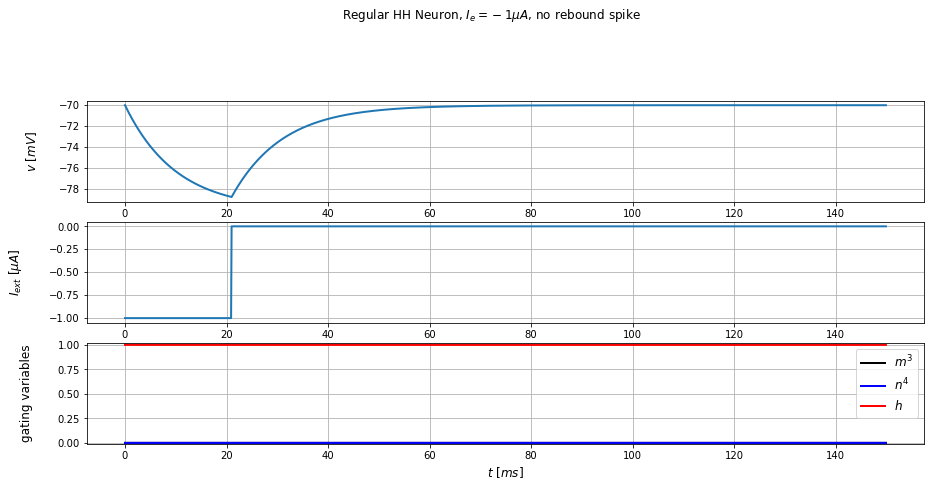

In [83]:
I_mins = [-1] #-1 -5, -10, -20, -50
sim_time = 150
for I_min in I_mins:
    current = input_factory.get_step_current(0, 20, b2.ms, I_min *b2.uA)
    state_monitor = simulate_HH_neuron_regular(current, sim_time * b2.ms)
    plot_data(state_monitor, title=f"Regular HH Neuron, $I_e = {I_min} \mu A$, no rebound spike", plot_ionic = False)

To better explain what is happening, we look at how the gating variables evolve when we stimulate with a positive current.

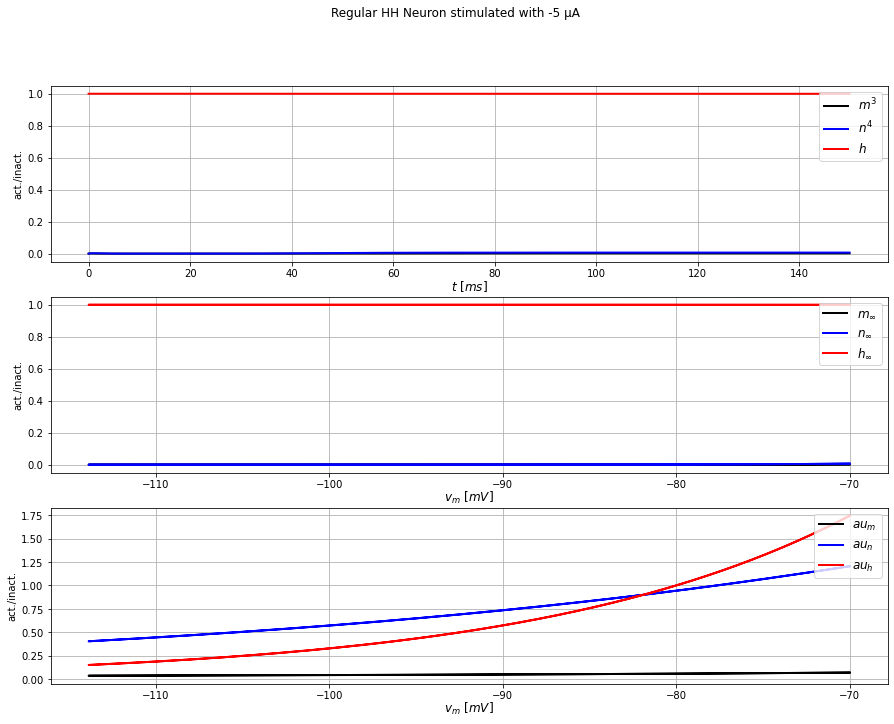

In [98]:
I_min = -5
sim_time = 150
current = input_factory.get_step_current(0, 20, b2.ms, I_min *b2.uA)
state_monitor = simulate_HH_neuron_regular(current, sim_time * b2.ms)
#plot_data(state_monitor, title=f"Regular HH Neuron stimulated with {I_min} µA", plot_ionic = False)
plot_gating_variables(state_monitor, title=f"Regular HH Neuron stimulated with {I_min} µA")

As can be seen on the figures, when the potential is very negative, the objective values m_inf, n_inf, h_inf are constant. In parallel, the time constants are very close (small => FAST). Therefore all the gating variables quickly go back to the same values and nothing changes => no spike. When the input current increases and the potential overpass -50, the objective values are already quite different: h_inf decreases to 0 to inactivate and m_inf increases to activate. Since t_h is much higher than t_m, the channel opens quickly and closes slowly => the current passes => a spike is generated.

## 1.3 Adaptation

We now simulate the adaptive neuron and investigate its differences with the regular spiking neuron.

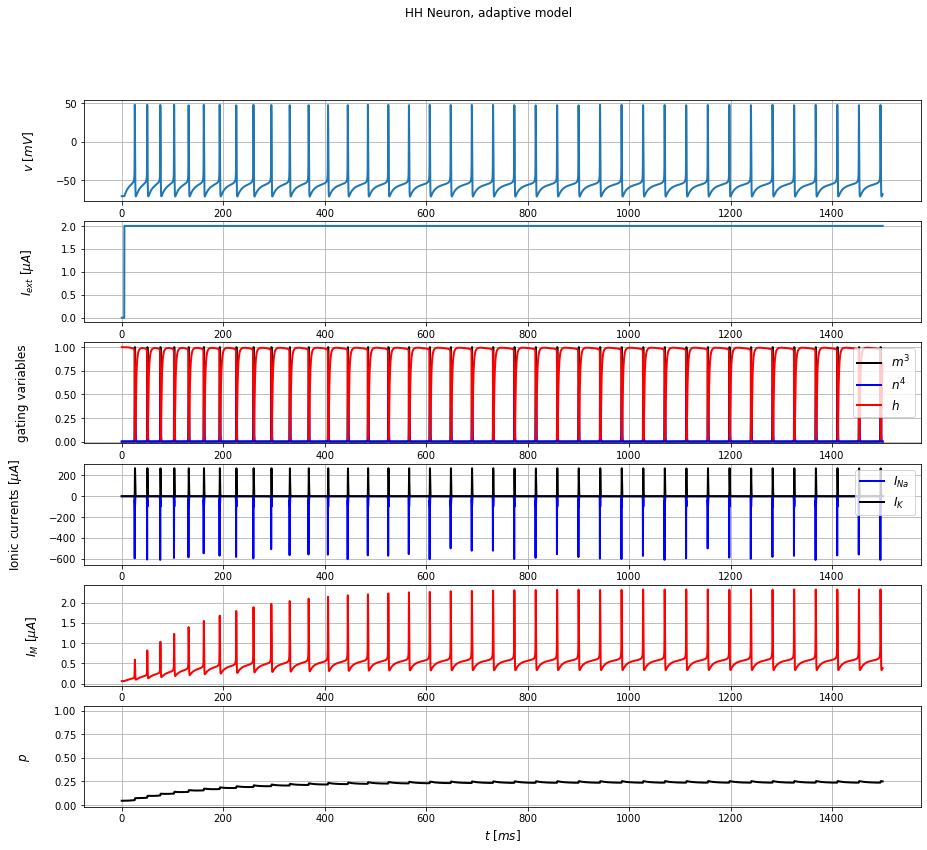

In [27]:
I_min = 2
sim_time = 1500
current = input_factory.get_step_current(5, 1500, b2.ms, I_min *b2.uA)
state_monitor_adaptive = simulate_HH_neuron_adaptive(current, sim_time * b2.ms)
plot_data(state_monitor_adaptive, title="HH Neuron, adaptive model", model_type=ModelType.ADAPTIVE)


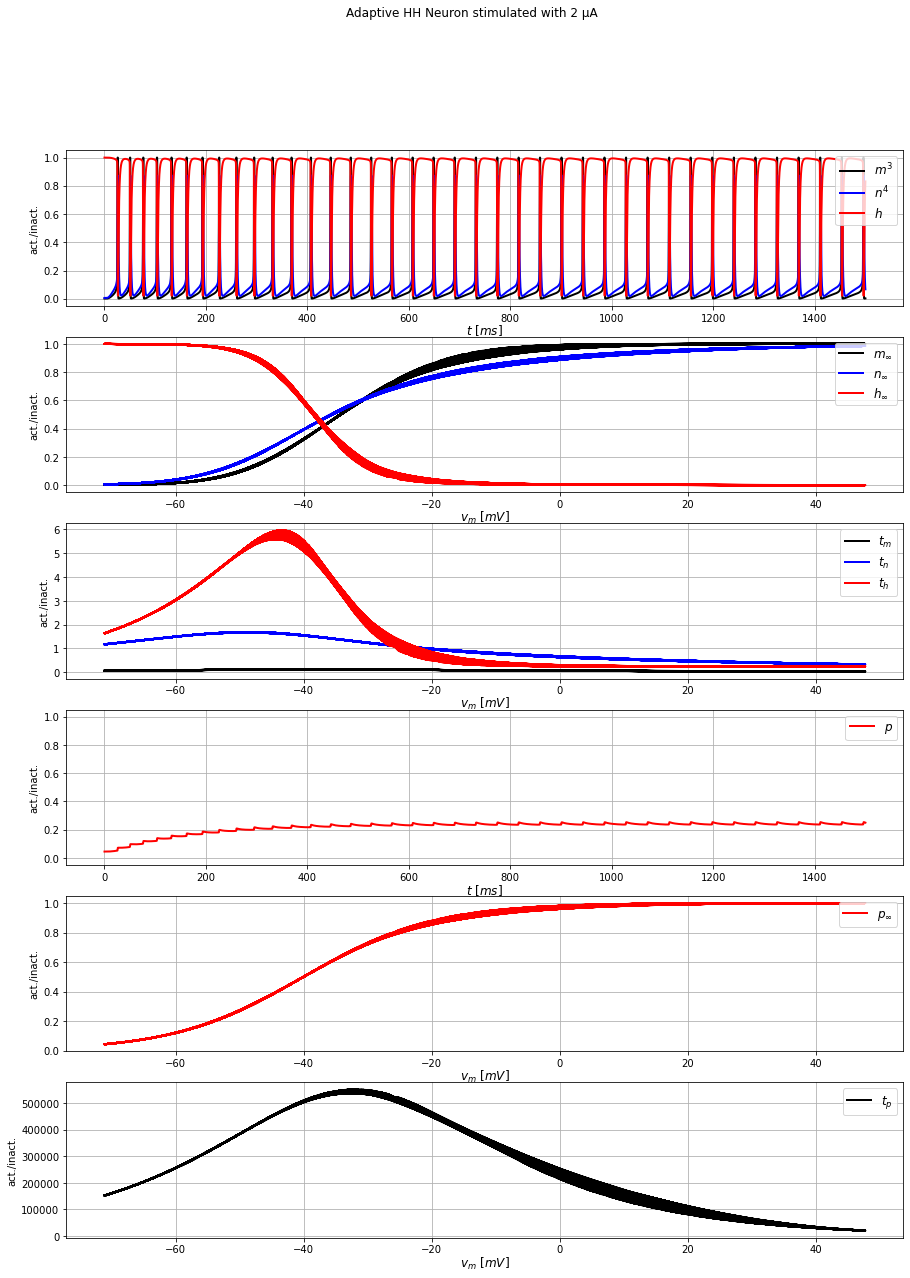

In [28]:
plot_gating_variables(state_monitor_adaptive, title=f"Adaptive HH Neuron stimulated with {I_min} µA",model_type=ModelType.ADAPTIVE)

We see that as the simulation goes on, the spike frequency decreases (spikes occur less often). This is due to the variable I_M (slow non activating current). At the moment of the spike, t_p becomes very small => fast change and p decreases quickly to EK (even lower). Then, right after the spike, V is very negative so t_p is bigger => slow increase, which makes the increase of V even slower than before => the time before the next spike will be bigger.

For comparison, here is the regular spiking neuron with the same setup. We see that the spikes are evenly spaced (no adaptation).

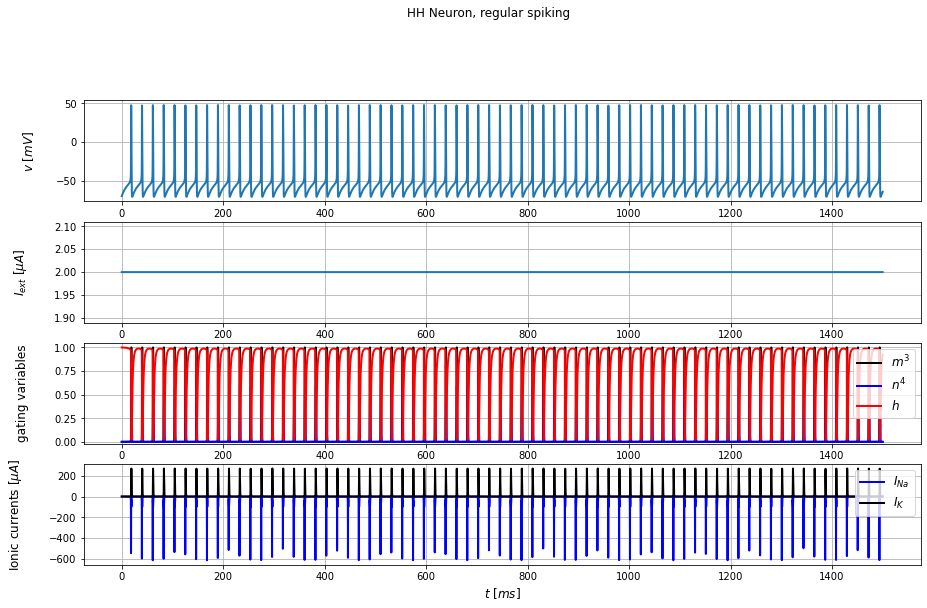

In [8]:
I_min = 2
sim_time = 1500
current = input_factory.get_step_current(0, 1500, b2.ms, I_min *b2.uA)
state_monitor = simulate_HH_neuron_regular(current, sim_time * b2.ms)
plot_data(state_monitor, title="HH Neuron, regular spiking")

We now define a function that extracts the spike timings. This allows us to extract the time between 2 consecutive spikes and plot the firing rate as the simulation goes on, which will be our measure of adaptation. In red is the the line defining the stable firing rate

In [6]:
def find_stable_point(signal, length_check = 4, tolerance = 0.1):
    means = []
    for i in range(signal.shape[0]-1):
        sum_i = 0.
        nb_i = 0.
        for n in range(length_check):
            if i+n < signal.shape[0]:
                sum_i += signal[i] - signal[i+n]
                nb_i += 1

        means.append(sum_i / nb_i)

    return np.argwhere(np.abs(np.array(means)) < tolerance)[0]

In [7]:
def extract_spike_timings(state_monitor, plot = True, length_check = 4, tolerance = 0.1):
    indices = np.argwhere(state_monitor.vm[0] > 0)[:,0]
    spike_timings = state_monitor.t[indices]

    # Remove noise (multiple measurements of the same spike)
    threshold = 0.01
    time_between_spikes = np.empty(spike_timings.shape)
    time_between_spikes[0] = np.inf  # always retain the 1st element
    time_between_spikes[1:] = np.diff(spike_timings)
    mask = time_between_spikes > threshold 

    time_between_spikes_cleaned = time_between_spikes[mask]
    time_between_spikes_cleaned[time_between_spikes_cleaned == np.inf] = 9999
    firing_rate = 1 / time_between_spikes_cleaned

    # Compute the point at which the firing rate is stable (change less thansome threshold)
    stable_index = find_stable_point(firing_rate, length_check, tolerance)

    stable_firing_rate = np.round(firing_rate[stable_index], 2)[0] 
    stable_firing_rate_time = np.round(state_monitor.t[indices[mask]][stable_index][0],3) / b2.ms


    if plot:
        plt.figure(figsize=(min(15,8 * state_monitor.vm[0].shape[0] / 200),8))
        plt.plot(state_monitor.t[indices[mask]] / b2.ms, firing_rate * b2.ms, label = 'Firing rate')
        plt.axvline(x=stable_firing_rate_time, lw = 3, color = 'r', linestyle = '--', label = f'Stable firing rate = {stable_firing_rate} Hz, reached at time t = {np.round(stable_firing_rate_time,2)} ms')
        plt.suptitle('Adaptive behaviour')
        plt.xlabel('Simulation time (ms)')
        plt.ylabel('Firing rate (Hz)')
        plt.legend()

    return firing_rate

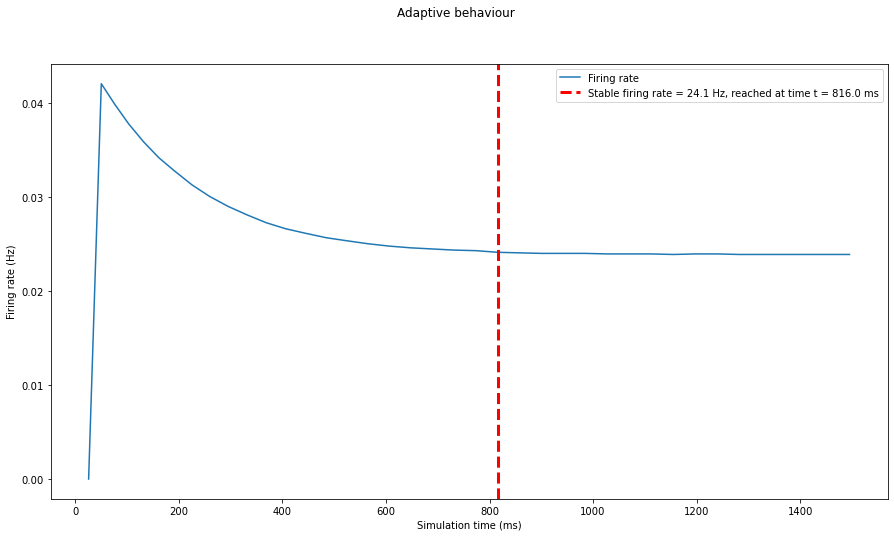

In [31]:
firing_rate = extract_spike_timings(state_monitor_adaptive)

Now that we have a measure of the adaptation, we want to slow down the adaptation rate (i.e the neuron takes more time to reach a stable firing rate)

This can be done by increasing the value scale of t_p from 2000 to 5000 (p takes more time to recover, so that the adaptation is slower)

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


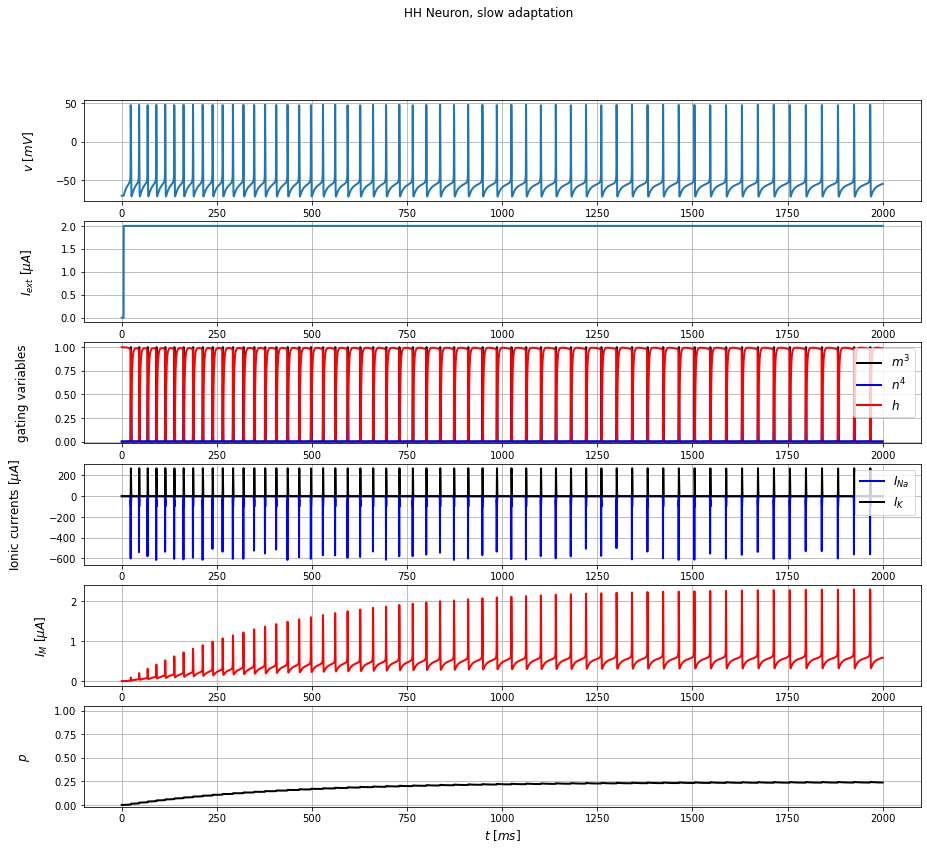

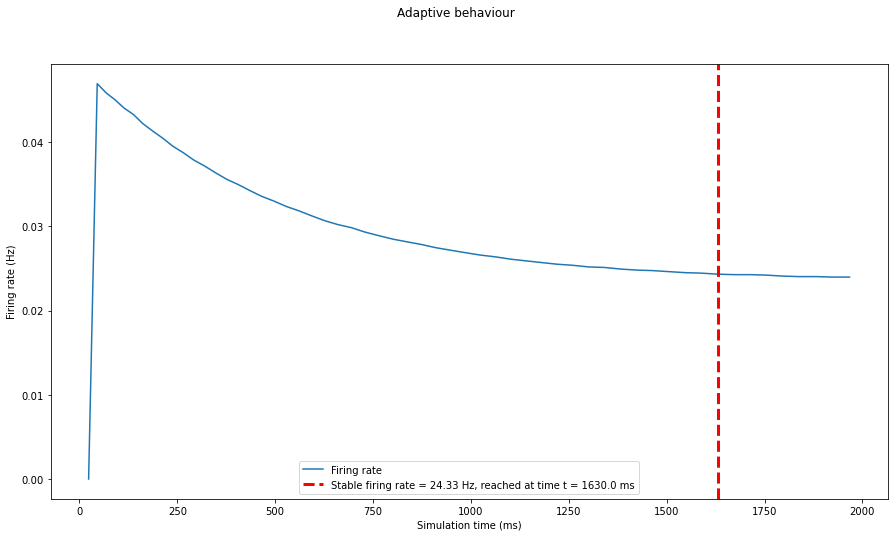

In [8]:
def simulate_HH_neuron_slow_adaptive(input_current, simulation_time, ):

    """An adaptive Hodgkin-Huxley neuron implemented in Brian2. Parameters are set 
    according to their values in the pdf.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h", "I_Na", "I_K", "I_M", "I_L, "p"]
    """

    # neuron parameters with their specific values
    El = -70 * b2.mV 
    EK = -90 * b2.mV 
    ENa = 50 * b2.mV 
    gl = 0.1 * b2.msiemens 
    gK = 5 * b2.msiemens 
    gNa = 50 * b2.msiemens 
    gm = 0.07 * b2.msiemens
    C = 1 * b2.ufarad 

    # forming HH model with differential equations 
    eqs = """
    I_e = input_current(t,i) : amp
    I_Na = gNa*m**3*h*(vm-ENa) : amp
    I_K = gK*n**4*(vm-EK) : amp
    I_L = gl*(vm-El)  : amp
    I_M = gm*p*(vm-EK): amp
    membrane_Im = I_e - I_Na  - I_L - I_K - I_M : amp
    alphah = .128*exp(-(43 + vm/mV)/18)/ms    : Hz
    alpham = -.32*(47 + vm/mV)/(exp(-0.25*(47+vm/mV))-1)/ms : Hz
    alphan = -.032*(45 + vm/mV)/(exp(-0.2*(45+vm/mV))-1)/ms : Hz
    betah = 4./(1+exp(-0.2*(20 + vm/mV)))/ms : Hz
    betam = 0.28*(20 + vm/mV)/(-1+exp(0.2*(20 + vm/mV)))/ms : Hz
    betan = .5*exp(-(50 + vm/mV)/40)/ms : Hz
    p_inf = 1./(1. + exp(-.1*(40 + vm/mV))) : 1
    t_p = 5000/(3.3*exp((20 + vm/mV)/20) + exp(-(20 + vm/mV)/20))*ms : second
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dp/dt = (p_inf - p)/t_p : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = -70 * b2.mV
    neuron.m = 0
    neuron.h = 1
    neuron.n = 0
    neuron.p = 0

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h", "I_Na", "I_K", "I_M", "I_L", "p"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

I_min = 2
sim_time = 2000
current = input_factory.get_step_current(5, sim_time, b2.ms, I_min *b2.uA)
state_monitor_slow_adaptive = simulate_HH_neuron_slow_adaptive(current, sim_time * b2.ms)
plot_data(state_monitor_slow_adaptive, title="HH Neuron, slow adaptation", model_type = ModelType.ADAPTIVE)
firing_rate = extract_spike_timings(state_monitor_slow_adaptive)

Now we want to decrease the stable firing rate without changing the adaptation rate

Decreasing the firing rate can be done by increasing the value of p_inf (exponential scaled by 45 instead of 40 at the denominator) and we can then decrease the value of t_p (scale by 1500 instead of 2000) to compensate and get the same adaptation rate.

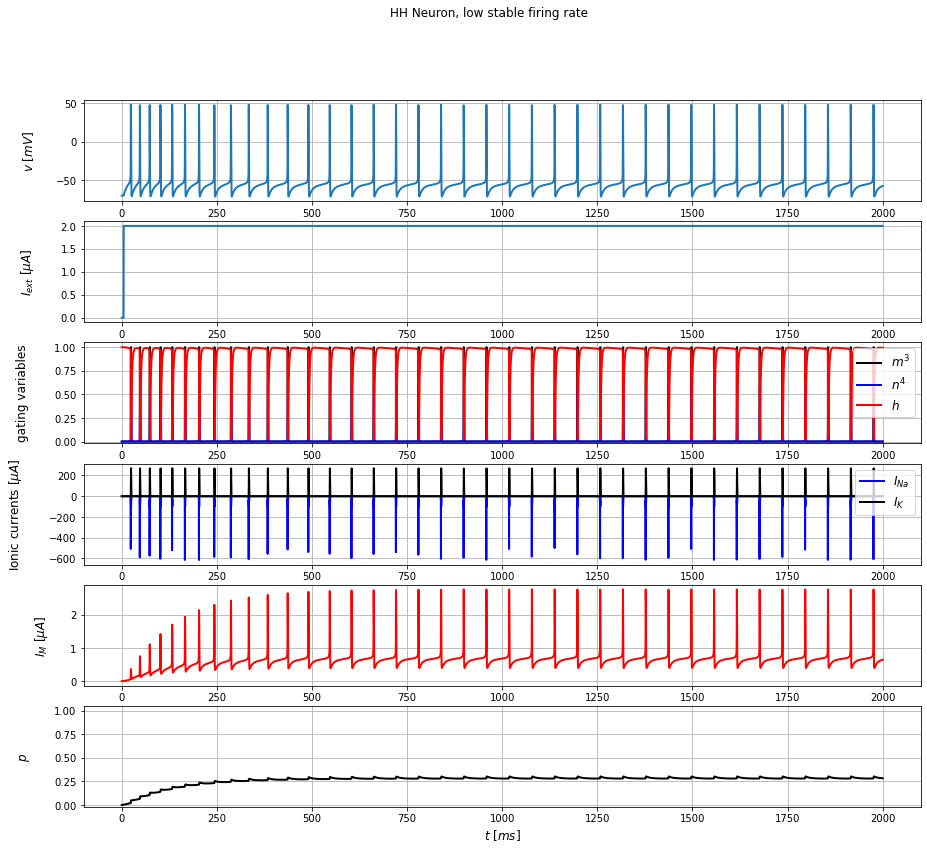

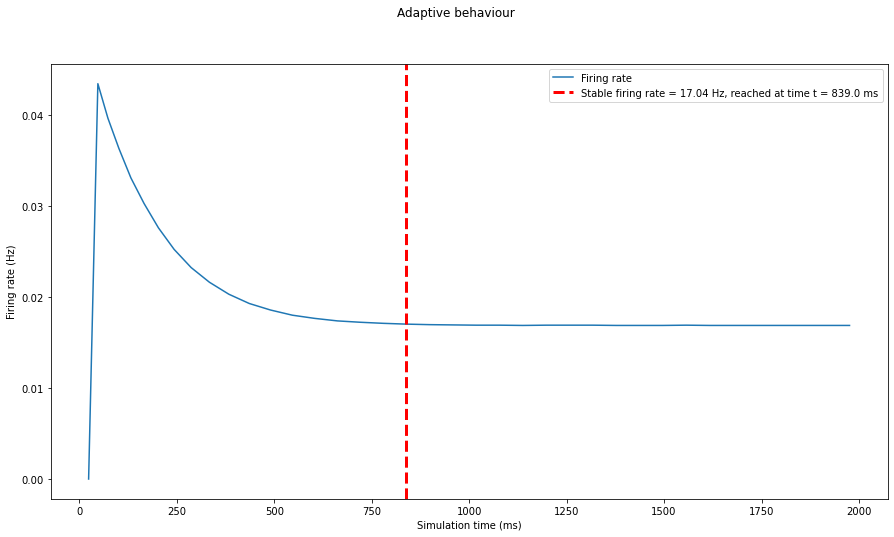

In [9]:
def simulate_HH_neuron_low_firing(input_current, simulation_time, ):

    """An adaptive Hodgkin-Huxley neuron implemented in Brian2. Parameters are set 
    according to their values in the pdf.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h", "I_Na", "I_K", "I_M", "I_L, "p"]
    """

    # neuron parameters with their specific values
    El = -70 * b2.mV 
    EK = -90 * b2.mV 
    ENa = 50 * b2.mV 
    gl = 0.1 * b2.msiemens 
    gK = 5 * b2.msiemens 
    gNa = 50 * b2.msiemens 
    gm = 0.07 * b2.msiemens
    C = 1 * b2.ufarad 

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    I_Na = gNa*m**3*h*(vm-ENa) : amp
    I_K = gK*n**4*(vm-EK) : amp
    I_L = gl*(vm-El)  : amp
    I_M = gm*p*(vm-EK): amp
    membrane_Im = I_e - I_Na  - I_L - I_K - I_M : amp
    alphah = .128*exp(-(43 + vm/mV)/18)/ms    : Hz
    alpham = -.32*(47 + vm/mV)/(exp(-0.25*(47+vm/mV))-1)/ms : Hz
    alphan = -.032*(45 + vm/mV)/(exp(-0.2*(45+vm/mV))-1)/ms : Hz
    betah = 4./(1+exp(-0.2*(20 + vm/mV)))/ms : Hz
    betam = 0.28*(20 + vm/mV)/(-1+exp(0.2*(20 + vm/mV)))/ms : Hz
    betan = .5*exp(-(50 + vm/mV)/40)/ms : Hz
    p_inf = 1./(1. + exp(-.1*(45 + vm/mV))) : 1
    t_p = 1500/(3.3*exp((20 + vm/mV)/20) + exp(-(20 + vm/mV)/20))*ms : second
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dp/dt = (p_inf - p)/t_p : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = -70 * b2.mV
    neuron.m = 0
    neuron.h = 1
    neuron.n = 0
    neuron.p = 0

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h", "I_Na", "I_K", "I_M", "I_L", "p"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

I_min = 2
sim_time = 2000
current = input_factory.get_step_current(5, sim_time, b2.ms, I_min *b2.uA)
state_monitor_low_firing = simulate_HH_neuron_low_firing(current, sim_time * b2.ms)
plot_data(state_monitor_low_firing, title="HH Neuron, low stable firing rate", model_type=ModelType.ADAPTIVE)
firing_rate = extract_spike_timings(state_monitor_low_firing)

Finally, we want to reverse the adaptation: make the stable firing rate higher than the initial one.

This is done by putting a '-' sign in front of I_M, which reverses its influence on the potential: when V is far from EK, I_M is big and pushes V even farther from it in the positive values, incentivizing it to spike.

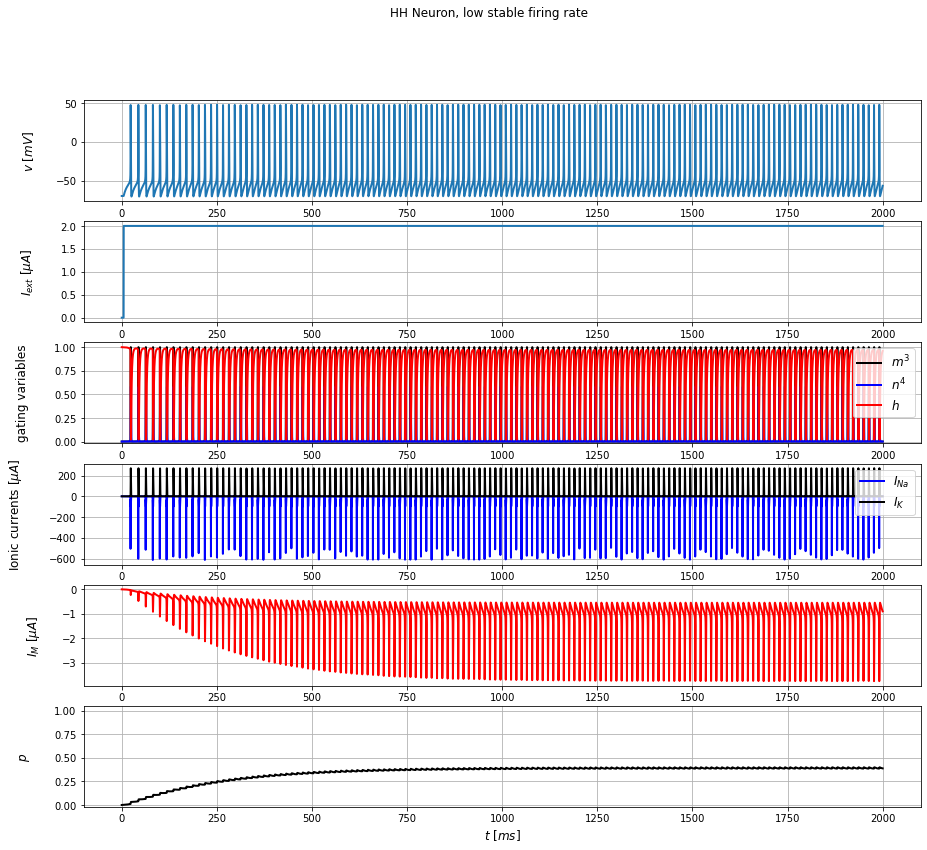

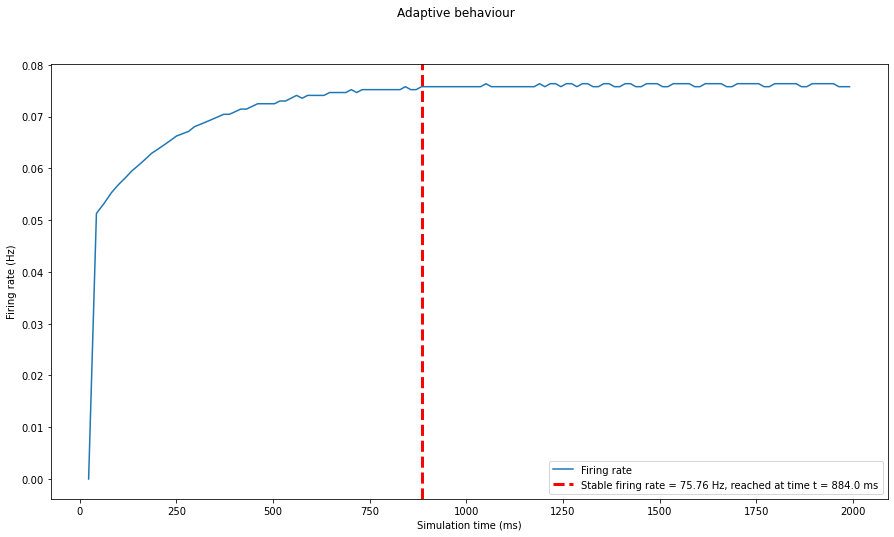

In [10]:
def simulate_HH_neuron_reverse_adaptation(input_current, simulation_time, ):

    """An adaptive Hodgkin-Huxley neuron implemented in Brian2. Parameters are set 
    according to their values in the pdf.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h", "I_Na", "I_K", "I_M", "I_L, "p"]
    """

    # neuron parameters with their specific values
    El = -70 * b2.mV 
    EK = -90 * b2.mV 
    ENa = 50 * b2.mV 
    gl = 0.1 * b2.msiemens 
    gK = 5 * b2.msiemens 
    gNa = 50 * b2.msiemens 
    gm = 0.07 * b2.msiemens
    C = 1 * b2.ufarad 

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    I_Na = gNa*m**3*h*(vm-ENa) : amp
    I_K = gK*n**4*(vm-EK) : amp
    I_L = gl*(vm-El)  : amp
    I_M = -gm*p*(vm-EK): amp
    membrane_Im = I_e - I_Na  - I_L - I_K - I_M : amp
    alphah = .128*exp(-(43 + vm/mV)/18)/ms    : Hz
    alpham = -.32*(47 + vm/mV)/(exp(-0.25*(47+vm/mV))-1)/ms : Hz
    alphan = -.032*(45 + vm/mV)/(exp(-0.2*(45+vm/mV))-1)/ms : Hz
    betah = 4./(1+exp(-0.2*(20 + vm/mV)))/ms : Hz
    betam = 0.28*(20 + vm/mV)/(-1+exp(0.2*(20 + vm/mV)))/ms : Hz
    betan = .5*exp(-(50 + vm/mV)/40)/ms : Hz
    p_inf = 1./(1. + exp(-.1*(40 + vm/mV))) : 1
    t_p = 2000/(3.3*exp((20 + vm/mV)/20) + exp(-(20 + vm/mV)/20))*ms : second
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dp/dt = (p_inf - p)/t_p : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = -70 * b2.mV
    neuron.m = 0
    neuron.h = 1
    neuron.n = 0
    neuron.p = 0

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h", "I_Na", "I_K", "I_M", "I_L", "p"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

I_min = 2
sim_time = 2000
current = input_factory.get_step_current(5, sim_time, b2.ms, I_min *b2.uA)
state_monitor_reverse = simulate_HH_neuron_reverse_adaptation(current, sim_time * b2.ms)
plot_data(state_monitor_reverse, title="HH Neuron, low stable firing rate", model_type=ModelType.ADAPTIVE)
firing_rate = extract_spike_timings(state_monitor_reverse, length_check=10, tolerance=0.00001)

# 2 From HH to AdEx

## 2.1 Passive properties

We want to extract the passive membrane parameters by looking at plots of the adaptive neuron.

- $\tau_m$, the membrane time scale, is obtained by inputing a short delta current, and check the time needed for the membrane potential to get $1/3$ - close to its original value.
- $R$, the membrane resistance, is obtained via the formula: $R = \frac{v_{max}-v_{rest}}{I}$ after the same experiment.
- $C$ is obtained via $C = \tau_m/R$
- $E_L$ is obtained with the following reasoning: looking at the equations for the adaptive model, if there is no input current and the ionic currents do not change, then the potential $V$ is equal to $E_L$. Therefore $E_L$ is the resting potential with 0 input current, so $E_L = -70$
- Finally, $g_L$, the leak channel's conductance, is directly computed as $g_L = \frac{1}{R}$

[TODO] For now, the values we find are inconsistent with the actual parameters and the scale in Exercise 1! In particular, the resistance found is $R = 1000$, while it should probably be $10 000$ instead.

tau_m = [6.5] ms
C =  1.01284327 uF
R =  [6.4175773] kohm
g_l =  [155.82204212] uS


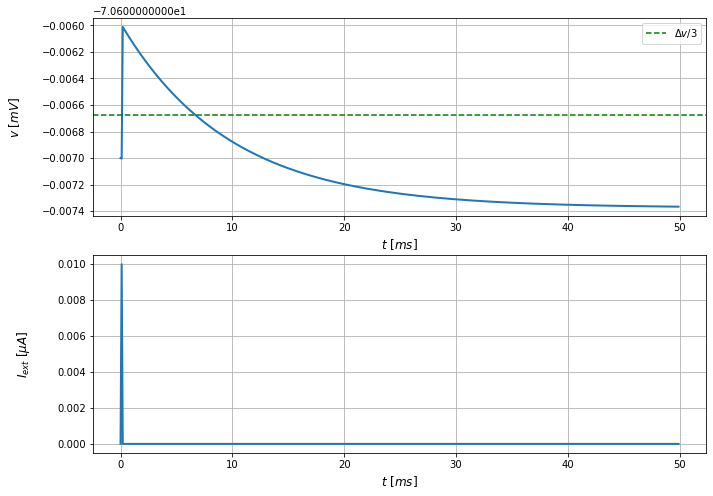

In [13]:
#time constant tau_m
I_min = 10 *b2.namp
I_start = 1
I_time = 0
unit_time=0.1*b2.ms

sim_time = 50
current = input_factory.get_step_current(I_start, I_start + I_time, unit_time, I_min)
state_monitor = simulate_HH_neuron_adaptive(current, sim_time * b2.ms)

v_rest = state_monitor.vm[0,0]
v_max = max(state_monitor.vm[0])
idx = np.argwhere( state_monitor.vm[0] - v_rest < 1/3 * (v_max - v_rest))
v_line=state_monitor.vm[0,idx[2]]/b2.mV
times = state_monitor.t[idx]
tau_m = (times[2] - state_monitor.t[2])
print('tau_m =',tau_m)

delta_t=0.1*b2.ms
delta_v=v_max-v_rest
C=I_min *delta_t/delta_v
R=tau_m/C
print('C = ', C)
print('R = ', R)
g_l = 1/R
print('g_l = ', g_l)

#plot_data(state_monitor, title="HH Neuron, adaptive model", model_type=ModelType.ADAPTIVE)

#plot only the potential, with horizontal line
plt.figure(figsize=(11,8))
plt.subplot(211)
plt.plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2)
plt.axhline(y=v_line, xmin=0, xmax=1, color='green', linestyle='--', label='$\Delta v / 3$')
plt.xlabel("$t\ [ms]$", fontsize=12)
plt.ylabel("$v\ [mV]$", fontsize=12, labelpad=20)
plt.grid()
plt.legend()

plt.subplot(212)
plt.plot(state_monitor.t / b2.ms, state_monitor.I_e[0] / b2.uamp, lw=2)
# plt.axis((
#     0,
#     np.max(state_monitor.t / b2.ms),
#     min(state_monitor.I_e[0] / b2.uamp) * 1.1,
#     max(state_monitor.I_e[0] / b2.uamp) * 1.1
# ))
plt.xlabel("$t\ [ms]$", fontsize=12)
plt.ylabel("$I_{ext}\ [\mu A]$", fontsize=12, labelpad=25)
plt.grid()

## 2.2 Exponential IF

We first define the function $f(V)$ and find its minimum and zeros.

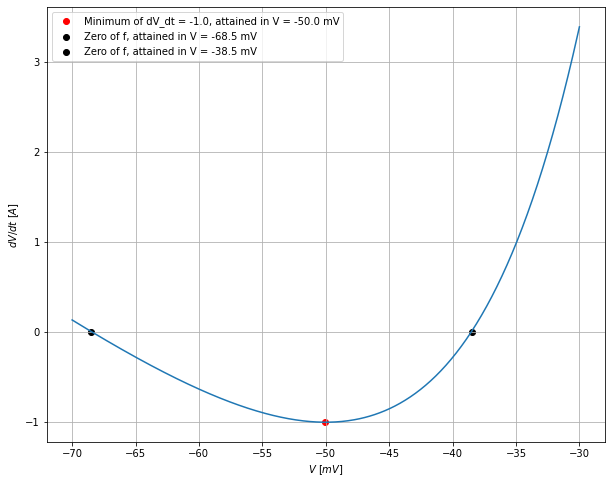

In [189]:
def f(V, delta_T, theta_rh, I_ext):
    gl = 0.1 * b2.msiemens
    El = -70 * b2.mV 

    return -gl * (V - El) + gl * delta_T * np.exp((V - theta_rh) / delta_T) + I_ext

V = np.linspace(-70,-30,400) * b2.mV

I_ext = 0 * b2.uA
f_V = f(V, 10 * b2.mV, -50 * b2.mV, I_ext) * 10 ** 6

# Find minimum of f
idx = np.argmin(f_V)
min_f = np.round(f_V[idx],2)
min_V = np.round(V[idx],2)  / b2.mV

# Find zeros of V
tolerance_zero = 0.01
idx_zeros = np.argwhere(np.abs(f_V) / b2.amp < tolerance_zero)

plt.figure(figsize=(10,8))
plt.plot(V / b2.mV, f_V)
plt.scatter(V[idx] / b2.mV, f_V[idx], color = 'r', label = f'Minimum of dV_dt = {min_f}, attained in V = {min_V} mV')
if idx_zeros.shape[0] != 0:
    zero_1 = np.round(V[idx_zeros[0]][0] / b2.mV,1)
    zero_2 = np.round(V[idx_zeros[-1]][0] / b2.mV,1)
    plt.scatter(zero_1 , 0 , color = 'k', label = f'Zero of f, attained in V = {zero_1} mV')
    plt.scatter(zero_2 , 0 , color = 'k', label = f'Zero of f, attained in V = {zero_2} mV')
plt.xlabel('$V\ [mV]$')
plt.ylabel('$dV/dt\ [A]$')
plt.legend()
plt.grid()

When V starts from V_rest and follows dynamics given by f(V), it always increases if min f(V) > 0. So we have to look for I_ext which brings the adpative neuron in this situation: before the spike, the potential should always be strictly increasing.

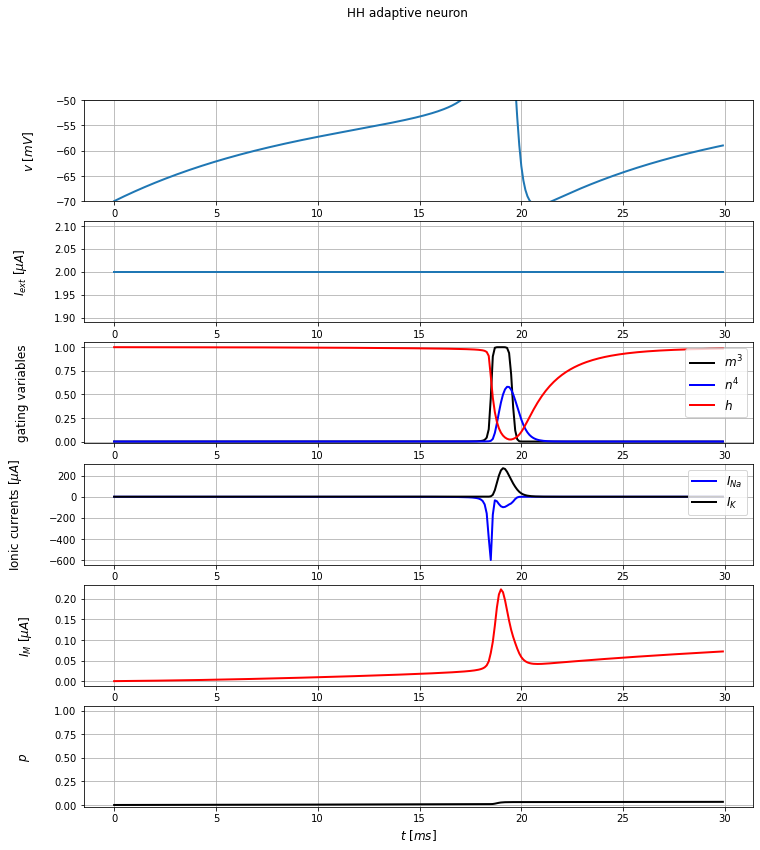

In [191]:
I_min = 2
sim_time = 30
current = input_factory.get_step_current(0, sim_time, b2.ms, I_min *b2.uA)
state_monitor_adaptive = simulate_HH_neuron_adaptive(current, sim_time * b2.ms)
plot_data(state_monitor_adaptive, title="HH adaptive neuron", model_type = ModelType.ADAPTIVE, vm_y_lim = (-70, -50))

We now want to find the value of $\theta_{rh}$. From the above-conducted analysis, we have to find the value of V at which its derivative is at a minimum. The derivative of V is computed by Forward Finite Differences using np.diff()

The value of theta_rh is -56.0 mV


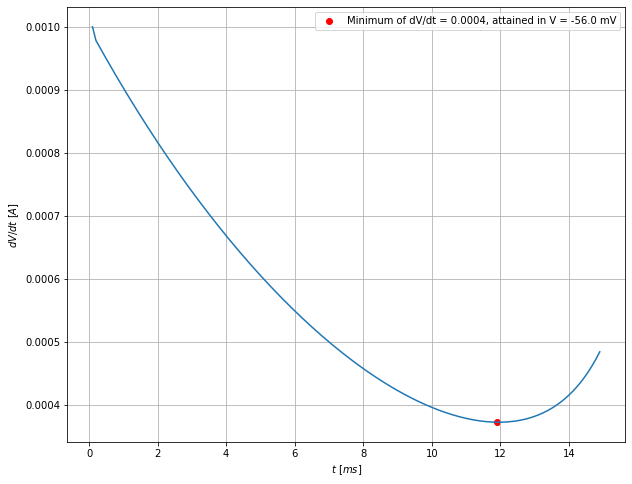

In [197]:
idx_lim = 150
V = state_monitor_adaptive.vm[0,1:idx_lim]

# Compute derivative by Forward FD
derivatives = np.empty(V.shape)
derivatives[0] = 0.001  
dt = sim_time / V.shape[0]
derivatives[1:] = np.diff(V) / dt

# Find minimum of derivatives
idx = np.argmin(derivatives)
min_f = np.round(derivatives[idx],4)
min_V = np.round(V[idx],3)  / b2.mV

idx_lim = 150

print(f'The value of theta_rh is {min_V} mV')
plt.figure(figsize=(10,8))
plt.plot(state_monitor_adaptive.t[1:idx_lim] / b2.ms, derivatives)
plt.scatter(state_monitor_adaptive.t[idx] / b2.ms, derivatives[idx], color = 'r', label = f'Minimum of dV/dt = {min_f}, attained in V = {min_V} mV')
plt.xlabel('$t\ [ms]$')
plt.ylabel('$dV/dt\ [A]$')
plt.legend()
plt.grid()
plt.show()
